# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

In [1]:
prefix="tumor_and_normal"

In [1]:
import warnings

import matplotlib

# import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
#import seaborn as sns

# import altair as alt
# import pertpy as pt
# from pandas.api.types import is_categorical_dtype
# from pandas import CategoricalDtype

In [9]:
#import decoupler as dc

In [2]:
from typing_extensions import Buffer

In [3]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path = f"{path}/data/local.h5ad"

In [4]:
adata = sc.read_h5ad(input_path)
nsclc_chrom = pd.read_csv(
    f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv"
)

In [5]:
adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts'

In [6]:
adata.obs.disease.value_counts()

lung adenocarcinoma                      704834
normal                                   212889
squamous cell lung carcinoma             190199
non-small cell lung carcinoma            120796
chronic obstructive pulmonary disease     55254
Name: disease, dtype: int64

In [7]:
adata.obs.tumor_stage.value_counts()

early         725412
advanced      288981
non-cancer    268143
Name: tumor_stage, dtype: int64

In [8]:
adata.obs.sex.value_counts()

male       676587
female     571042
unknown     36343
Name: sex, dtype: int64

In [9]:
adata.obs.origin.value_counts()

tumor_primary       585138
normal_adjacent     345211
normal              281363
tumor_metastasis     71272
nan                    988
Name: origin, dtype: int64

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [10]:
adata = adata[
    (adata.obs["disease"] != "normal")
    & (adata.obs["disease"] != "chronic obstructive pulmonary disease")
]  # exclude normal and COPD samples
adata = adata[adata.obs["tumor_stage"].notna()]  # exclude samples without tumor stage
adata = adata[(adata.obs["sex"] == "male") | (adata.obs["sex"] == "female")]

In [11]:
adata = adata[
    (adata.obs["origin"] == "tumor_primary")
    | (adata.obs["origin"] == "normal_adjacent")
]

In [12]:
adata.obs.disease.value_counts()

lung adenocarcinoma              577317
squamous cell lung carcinoma     189044
non-small cell lung carcinoma    120796
Name: disease, dtype: int64

In [13]:
adata.obs.tumor_stage.value_counts()

early       672760
advanced    214397
Name: tumor_stage, dtype: int64

In [14]:
adata.obs.sex.value_counts()

male      500302
female    386855
Name: sex, dtype: int64

In [15]:
adata.obs.origin.value_counts()

tumor_primary      571045
normal_adjacent    316112
Name: origin, dtype: int64

## Patern recognition receptors

In [16]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
adata.var.set_index("feature_name", inplace=True)

In [18]:
gene_list = ["NLRP1",
"AIM2",
"IFIH1",
"MYD88",
"NFKB1",
"NFKB2",
"IRAK1",
"IRAK2",
"IRAK4",
"MAP3K7",
#"TRIF",
"TRAF6",
"IL18",
"IRF3",
"IRF7",
"TRAF3",
#"RIP1",
"FOS",
"JUN",
"IKBKG",
"MAP2K3",
#"MAP32K4",
"MAP2K6",
"MAP2K7",
"IL1B",
"IL1A"]

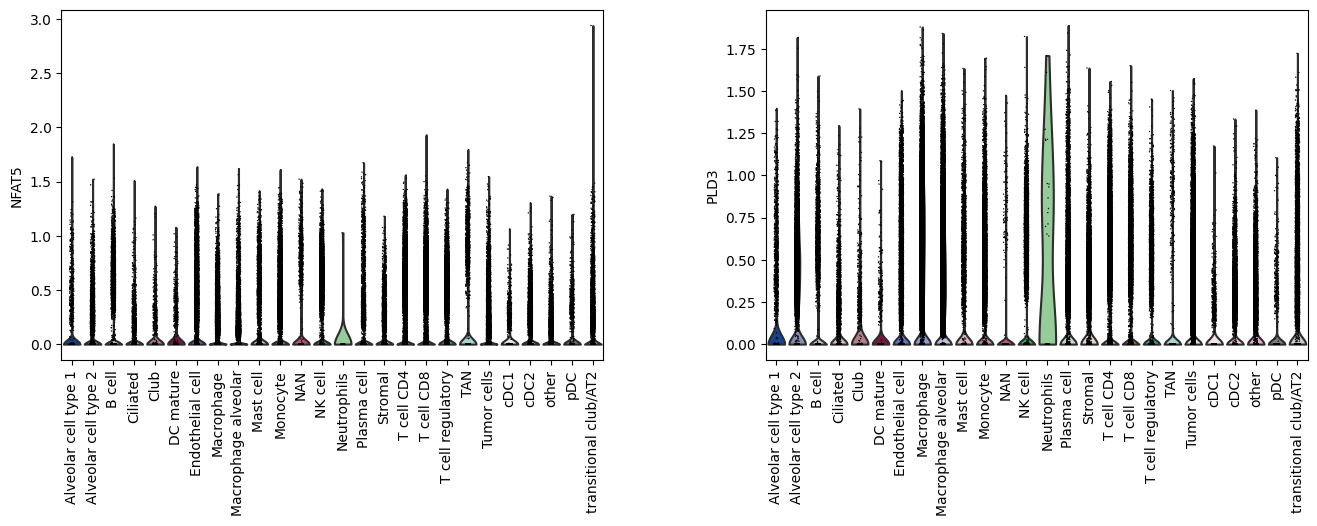

In [36]:
sc.pl.violin(adata, keys=['NFAT5','PLD3'], use_raw=False,groupby='cell_type_neutro_coarse',gene_symbols="feature_name", rotation=90,layer ="log1p_norm",save = "2_prr.png" )

In [27]:
adata.var.index.rename("index",inplace = True)

In [28]:
adata.raw.var.index = adata.raw.var.feature_name

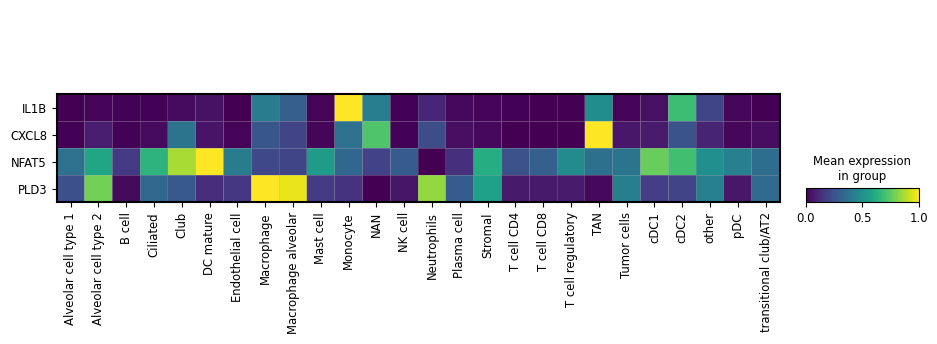

In [29]:
markers = ['IL1B', 'CXCL8','NFAT5','PLD3']
sc.pl.matrixplot(adata, markers, groupby='cell_type_neutro_coarse', dendrogram=False, log=True , standard_scale='var', swap_axes=True, save= "prr.png")

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


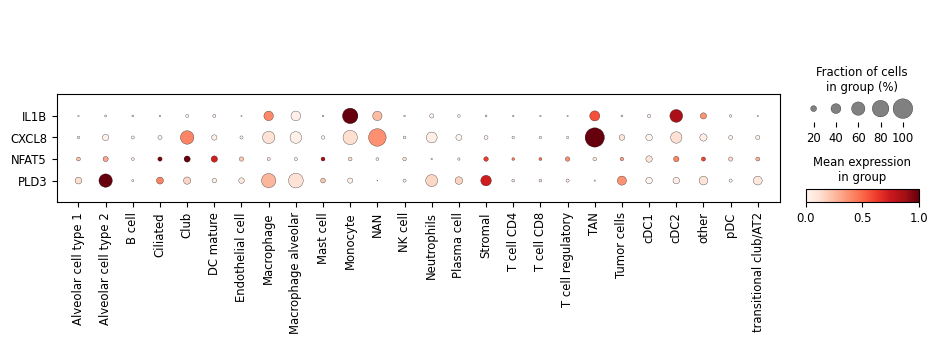

In [37]:
markers = ['IL1B', 'CXCL8','NFAT5','PLD3']
sc.pl.dotplot(adata, markers, groupby='cell_type_neutro_coarse', dendrogram=False, standard_scale='var', swap_axes=True, save= "prr.png" )
#sc.pl.matrixplot(adata, markers, groupby='cell_type_neutro_coarse', dendrogram=False, log=True , standard_scale='var', swap_axes=True, save= "prr.png")

### 02.CELL TPYE RE-CLASIFICATION 

In [85]:
adata.obs.cell_type.value_counts()

CD4-positive, alpha-beta T cell         152247
CD8-positive, alpha-beta T cell         123252
alveolar macrophage                      82844
macrophage                               78660
malignant cell                           75457
natural killer cell                      50680
B cell                                   44609
classical monocyte                       43364
regulatory T cell                        33603
plasma cell                              31876
epithelial cell of lung                  23013
CD1c-positive myeloid dendritic cell     20734
neutrophil                               18706
type II pneumocyte                       16274
vein endothelial cell                    15849
mast cell                                14361
capillary endothelial cell               10870
multi-ciliated epithelial cell            6413
non-classical monocyte                    6103
myeloid cell                              5544
fibroblast of lung                        5091
bronchus fibr

In [86]:
adata.obs.cell_type_major.value_counts()

T cell CD4               149343
T cell CD8               120586
Macrophage alveolar       82844
Macrophage                78660
Tumor cells               75457
NK cell                   50094
Monocyte                  49467
B cell                    44307
T cell regulatory         33603
Endothelial cell          32443
Plasma cell               30292
transitional club/AT2     22894
cDC2                      20734
Neutrophils               18706
Alveolar cell type 2      16274
Mast cell                 14361
other                     14017
Stromal                   13948
Ciliated                   6413
pDC                        3800
Alveolar cell type 1       3739
cDC1                       2097
Club                       1580
DC mature                  1498
Name: cell_type_major, dtype: int64

In [87]:
cells_of_interest = [
    "alveolar macrophage",
    "neutrophil",
    "macrophage",
    "malignant cell",
    "B cell",
    "regulatory T cell",
    "CD4-positive, alpha-beta T cell",
    "CD8-positive, alpha-beta T cell",
    "neutrophils",
    "epithelial cell of lung",
    "multi-ciliated epithelial cell",
]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)]

In [88]:
set(subset_adata.obs.cell_type)

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'alveolar macrophage',
 'epithelial cell of lung',
 'macrophage',
 'malignant cell',
 'multi-ciliated epithelial cell',
 'neutrophil',
 'regulatory T cell'}

In [89]:
set(subset_adata.obs.cell_type_major)

{'B cell',
 'Ciliated',
 'Macrophage',
 'Macrophage alveolar',
 'Neutrophils',
 'T cell CD4',
 'T cell CD8',
 'T cell regulatory',
 'Tumor cells',
 'other',
 'transitional club/AT2'}

In [90]:
subset_adata.obs["cell_type"] = subset_adata.obs["cell_type"].replace(
    [
        "epithelial cell of lung",
        "multi-ciliated epithelial cell",
    ],
    "epithelial cell",
)
subset_adata.obs["cell_type"] = subset_adata.obs["cell_type"].replace(
    ["alveolar macrophage"], "macrophage"
)
subset_adata.obs["cell_type"] = subset_adata.obs["cell_type"].replace(
    ["CD4-positive, alpha-beta T cell"], "CD4+ T cell"
)
subset_adata.obs["cell_type"] = subset_adata.obs["cell_type"].replace(
    ["CD8-positive, alpha-beta T cell"], "CD8+ T cell"
)

/tmp/ipykernel_572790/2170802957.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')


In [91]:
set(subset_adata.obs.cell_type)

{'B cell',
 'CD4+ T cell',
 'CD8+ T cell',
 'epithelial cell',
 'macrophage',
 'malignant cell',
 'neutrophil',
 'regulatory T cell'}

In [92]:
subset_adata

AnnData object with n_obs × n_vars = 638804 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [ ]:
adata

Number of cells: 
- Original adata 1283972
- Adata after filtering for disease, sex, origin, tumor stage  887157
- Subset adata for cells of interest and renaming 638804

- In 00_get_chromosome I have retrieved the information for the chromosome and I append to subset_adata.

- Compute DEG (male vs female)
  Separate into 3 dataframes: autosomal_adata, xchrom_adata, ychrom_adata
- Create bar plot to compare Number of DEG in TUMOR vs NORMAL 

### 03.Get X, Y and autosomal genes

In [ ]:
nsclc_chrom = nsclc_chrom.rename(columns={"ensembl_gene_id": "gene_id"})
nsclc_chrom = nsclc_chrom.iloc[:, 1:]
nsclc_chrom = nsclc_chrom.set_index("gene_id")
nsclc_chrom["gene_id"] = nsclc_chrom.index

In [ ]:
subset_adata.var["gene_id"] = subset_adata.var_names
subset_adata_var_chrom = pd.concat([subset_adata.var, nsclc_chrom], axis=1)
subset_adata.var = subset_adata_var_chrom

In [ ]:
subset_adata.var["chromosome_name"] = subset_adata.var["chromosome_name"].astype(str)

In [ ]:
subset_indices = subset_adata.var["chromosome_name"] == "X"

# Subset adata to keep only the genes with chromosome 'X'
xchrom_adata = subset_adata[:, subset_indices]

In [ ]:
subset_indices = subset_adata.var["chromosome_name"] == "Y"

# Subset adata to keep only the genes with chromosome 'Y'
ychrom_adata = subset_adata[:, subset_indices]

In [ ]:
subset_indices = (subset_adata.var["chromosome_name"] != "Y") & (
    subset_adata.var["chromosome_name"] != "X"
)

# Subset adata to keep only the genes with chromosome 'Y'
autosomal_adata = subset_adata[:, subset_indices]

In [ ]:
# xchrom_adata.var.to_csv(f"{path}/out/007_re_analysis/tables/input/xchrom_adata_var.csv")
# ychrom_adata.var.to_csv(f"{path}/out/007_re_analysis/tables/input/ychrom_adata_var.csv")
# autosomal_adata.var.to_csv(f"{path}/out/007_re_analysis/tables/input/autosomal_adata_var.csv")

In [42]:
xchrom_adata.shape

(638804, 618)

In [43]:
ychrom_adata.shape

(638804, 16)

In [41]:
autosomal_adata.shape

(638804, 17177)

## Transcription factor activity inference
### Load results from DESEQ2 

In [228]:
resDir = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/007_re_analysis/figures/decoupler"

In [4]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism="human")
collectri

0.00B [00:00, ?B/s]

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [50]:
deseq_out = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/007_re_analysis/tables/deseq2_out"
deseq_res_normal = pd.read_csv(
    f"{deseq_out}/nsclc_gender_normal_all_genes_DESeq2_result.csv"
)
deseq_res_tumor = pd.read_csv(
    f"{deseq_out}/nsclc_gender_tumor_all_genes_DESeq2_result.csv"
)
deseq_res_normal_and_tumor = pd.read_csv(
    f"{deseq_out}/nsclc_gender_tumor_and_normal_all_genes_DESeq2_result.csv"
)

In [51]:
deseq_res_normal.set_index("gene_name", inplace=True)
deseq_res_normal = deseq_res_normal[~deseq_res_normal.index.duplicated(keep="first")]
mat_normal = deseq_res_normal[["stat"]].T.rename(index={"stat": "normal"})
# Infer pathway activities with ulm
tf_acts_normal, tf_pvals_normal = dc.run_ulm(mat=mat_normal, net=collectri)

In [52]:
deseq_res_tumor.set_index("gene_name", inplace=True)
deseq_res_tumor = deseq_res_tumor[~deseq_res_tumor.index.duplicated(keep="first")]
mat_tumor = deseq_res_tumor[["stat"]].T.rename(index={"stat": "tumor"})
# Infer pathway activities with ulm
tf_acts_tumor, tf_pvals_tumor = dc.run_ulm(mat=mat_tumor, net=collectri)

In [53]:
deseq_res_normal_and_tumor.set_index("gene_name", inplace=True)
mat_tumor_and_normal = deseq_res_normal_and_tumor[["stat"]].T.rename(
    index={"stat": "tumor_and_normal"}
)
# Infer pathway activities with ulm
tf_acts_tumor_and_normal, tf_pvals_tumor_and_normal = dc.run_ulm(
    mat=mat_tumor_and_normal, net=collectri
)

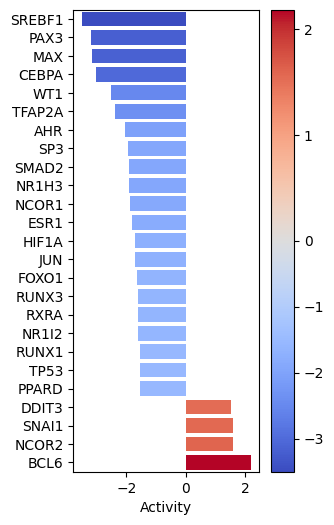

In [43]:
dc.plot_barplot(
    acts=tf_acts_normal,
    contrast="normal",
    top=25,
    vertical=True,
    figsize=(3, 6),
    save=f"{resDir}/transcription_factor_normal.png",
)

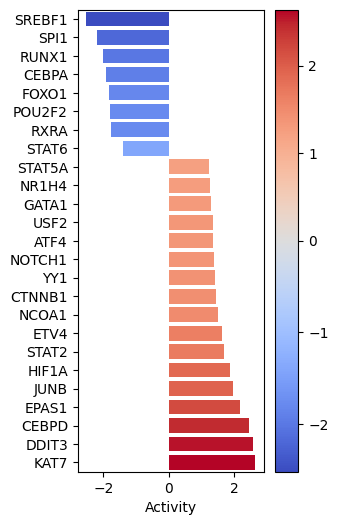

In [44]:
dc.plot_barplot(
    acts=tf_acts_tumor,
    contrast="tumor",
    top=25,
    vertical=True,
    figsize=(3, 6),
    save=f"{resDir}/transcription_factor_tumor.png",
)

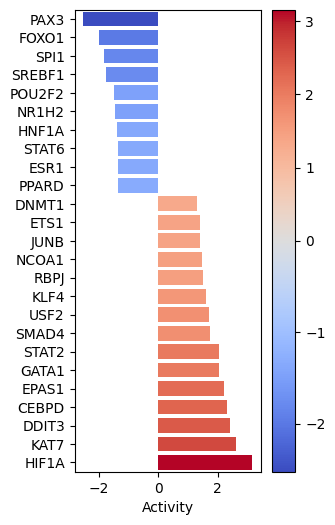

In [45]:
dc.plot_barplot(
    acts=tf_acts,
    contrast="tumor_and_normal",
    top=25,
    vertical=True,
    figsize=(3, 6),
    save=f"{resDir}/transcription_factor_tumor_and_normal.png",
)

## PROGENY 

In [46]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,NME7,-2.504800,1.493383e-06
6996,p53,ZMYM4,-2.325752,1.522388e-06
6997,p53,CFDP1,-1.628168,1.526045e-06
6998,p53,VPS37D,2.309503,1.537098e-06


In [54]:
# Infer pathway activities with mlm
pathway_acts_normal, pathway_pvals_normal = dc.run_mlm(mat=mat_normal, net=progeny)
pathway_acts_normal

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,TGFb,TNFa,Trail,VEGF,WNT,p53
normal,-0.241452,2.742038,1.590018,0.829323,0.045135,-2.157756,0.973686,-0.207757,-0.603891,2.106783,-0.793923,-1.174347,0.021514


In [55]:
# Infer pathway activities with mlm
pathway_acts_tumor, pathway_pvals_tumor = dc.run_mlm(mat=mat_tumor, net=progeny)
pathway_acts_tumor

,Androgen,EGFR,Estrogen,JAK-STAT,MAPK,NFkB,TNFa,VEGF,WNT,p53
tumor,-0.43322,-0.140791,-2.112656,-1.099511,-0.639771,0.551705,-0.601997,0.404442,-1.022632,-1.184204


In [56]:
# Infer pathway activities with mlm
pathway_acts_tumor_and_normal, pathway_pvals_tumor_and_normal = dc.run_mlm(
    mat=mat_tumor_and_normal, net=progeny
)
pathway_acts_tumor_and_normal

,Androgen,EGFR,Estrogen,JAK-STAT,MAPK,NFkB,TGFb,TNFa,Trail,VEGF,WNT,p53
tumor_and_normal,-0.124345,-0.924454,-2.789944,-1.221292,-0.014588,1.514274,0.138937,-1.255128,-0.257705,0.62032,-1.532702,-0.846826


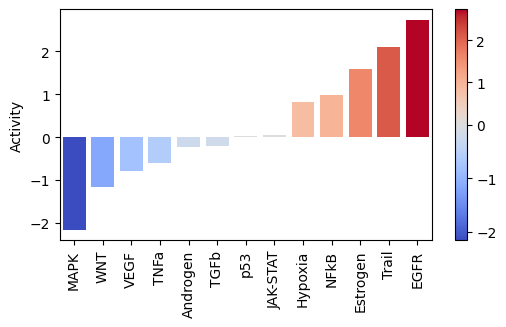

In [61]:
dc.plot_barplot(
    acts=pathway_acts_normal,
    contrast="normal",
    top=25,
    vertical=False,
    figsize=(6, 3),
    save=f"{resDir}/progeny_pathways_normal.png",
)

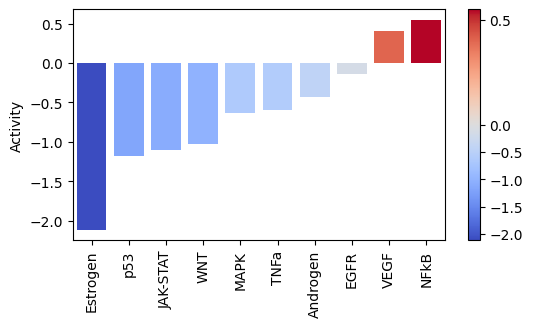

In [62]:
dc.plot_barplot(
    acts=pathway_acts_tumor,
    contrast="tumor",
    top=25,
    vertical=False,
    figsize=(6, 3),
    save=f"{resDir}/progeny_pathways__tumor.png",
)

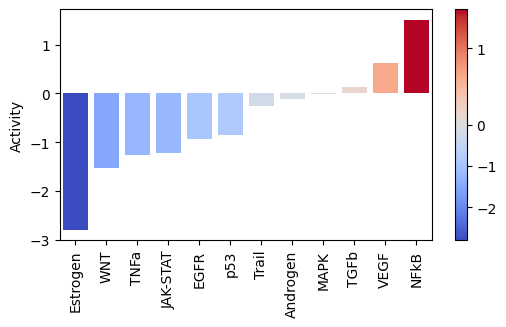

In [63]:
dc.plot_barplot(
    acts=pathway_acts_tumor_and_normal,
    contrast="tumor_and_normal",
    top=25,
    vertical=False,
    figsize=(6, 3),
    save=f"{resDir}/progeny_pathways__tumor_and_normal.png",
)

## SC Pathway activity inference

In [ ]:
progeny = dc.get_progeny(organism="human", top=500)

In [99]:
subset_adata.var["gene_id"] = subset_adata.var.index

In [101]:
subset_adata.var.set_index("feature_name", inplace=True)

In [117]:
subset_adata.var.index.rename("index",inplace = True)

In [ ]:
subset_adata.raw.var.index = subset_adata.raw.var.feature_name

In [177]:
dc.run_mlm(
    mat=subset_adata,
    net=progeny,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
)

Running mlm on mat with 638804 samples and 17811 targets for 14 sources.


100%|██████████| 64/64 [09:05<00:00,  8.53s/it]


In [178]:
subset_adata.obsm["mlm_estimate"]

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACCCAAGAGCCATG-1_0-1,-0.491594,0.057151,0.121406,0.598365,0.989726,-0.491019,1.772198,-0.750225,-0.283499,-0.258706,-0.996463,-0.434491,-0.121263,-0.652269
AAACCCAAGATTAGAC-1_0-1,0.643365,0.641756,-0.290453,0.202765,0.663411,-0.400839,-0.464452,0.425819,-0.900883,0.297172,-1.571066,0.053900,-0.058456,-0.225732
AAACCCAAGGTCGCCT-1_0-1,-0.254079,0.423200,-0.404513,0.368914,0.933463,-0.547602,-0.683023,-0.093123,-0.584421,0.755512,-0.073128,0.020253,0.054664,-0.371049
AAACCCAAGTCATTGC-1_0-1,0.184239,1.152927,-0.275863,0.015234,0.731056,-1.013506,-0.589087,-2.644645,-0.367562,0.976734,0.065790,-1.036229,-0.136624,-0.653843
AAACCCACACTCCTTG-1_0-1,-0.170938,0.959639,-0.763232,1.190994,0.220922,-0.296641,1.527747,-1.420762,-0.585409,-0.550638,-0.825923,-0.601435,0.146632,0.570653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGCCTTGG-1-38-8,-0.009604,0.430641,0.020259,1.184905,0.433644,-0.712394,-0.511824,-0.485137,0.061462,1.022478,0.349329,-0.304315,0.202680,-0.242069
TTTGTCACAGGTCGTC-1-38-8,-0.148964,1.208335,-0.235299,1.034758,0.916251,-1.099014,0.273914,-0.462588,0.093068,1.099675,0.867274,-0.631535,0.275615,-0.397556
TTTGTCACATCTATGG-1-38-8,-0.415422,1.890339,-0.207670,2.815181,5.273443,-1.946786,-0.909335,-1.187628,-0.587838,2.239932,0.027501,0.044693,0.288627,0.274263
TTTGTCAGTGTTGGGA-1-38-8,-0.255437,0.640214,-0.038399,0.794160,2.550828,-1.318362,-0.833463,-1.899998,-0.532746,2.297652,0.365739,0.165333,0.270240,0.004436


In [179]:
subset_adata.obsm["progeny_mlm_estimate"] = subset_adata.obsm["mlm_estimate"].copy()
subset_adata.obsm["progeny_mlm_pvals"] = subset_adata.obsm["mlm_pvals"].copy()
subset_adata

AnnData object with n_obs × n_vars = 638804 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [224]:
acts = dc.get_acts(subset_adata, obsm_key="mlm_estimate")
acts

AnnData object with n_obs × n_vars = 638804 × 14
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    uns: '_scvi', 'ann_fine_colors', 'batch_condition', 'cell_

In [189]:
acts.obsm["mlm_estimate"]

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACCCAAGAGCCATG-1_0-1,-0.491594,0.057151,0.121406,0.598365,0.989726,-0.491019,1.772198,-0.750225,-0.283499,-0.258706,-0.996463,-0.434491,-0.121263,-0.652269
AAACCCAAGATTAGAC-1_0-1,0.643365,0.641756,-0.290453,0.202765,0.663411,-0.400839,-0.464452,0.425819,-0.900883,0.297172,-1.571066,0.053900,-0.058456,-0.225732
AAACCCAAGGTCGCCT-1_0-1,-0.254079,0.423200,-0.404513,0.368914,0.933463,-0.547602,-0.683023,-0.093123,-0.584421,0.755512,-0.073128,0.020253,0.054664,-0.371049
AAACCCAAGTCATTGC-1_0-1,0.184239,1.152927,-0.275863,0.015234,0.731056,-1.013506,-0.589087,-2.644645,-0.367562,0.976734,0.065790,-1.036229,-0.136624,-0.653843
AAACCCACACTCCTTG-1_0-1,-0.170938,0.959639,-0.763232,1.190994,0.220922,-0.296641,1.527747,-1.420762,-0.585409,-0.550638,-0.825923,-0.601435,0.146632,0.570653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGCCTTGG-1-38-8,-0.009604,0.430641,0.020259,1.184905,0.433644,-0.712394,-0.511824,-0.485137,0.061462,1.022478,0.349329,-0.304315,0.202680,-0.242069
TTTGTCACAGGTCGTC-1-38-8,-0.148964,1.208335,-0.235299,1.034758,0.916251,-1.099014,0.273914,-0.462588,0.093068,1.099675,0.867274,-0.631535,0.275615,-0.397556
TTTGTCACATCTATGG-1-38-8,-0.415422,1.890339,-0.207670,2.815181,5.273443,-1.946786,-0.909335,-1.187628,-0.587838,2.239932,0.027501,0.044693,0.288627,0.274263
TTTGTCAGTGTTGGGA-1-38-8,-0.255437,0.640214,-0.038399,0.794160,2.550828,-1.318362,-0.833463,-1.899998,-0.532746,2.297652,0.365739,0.165333,0.270240,0.004436


/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


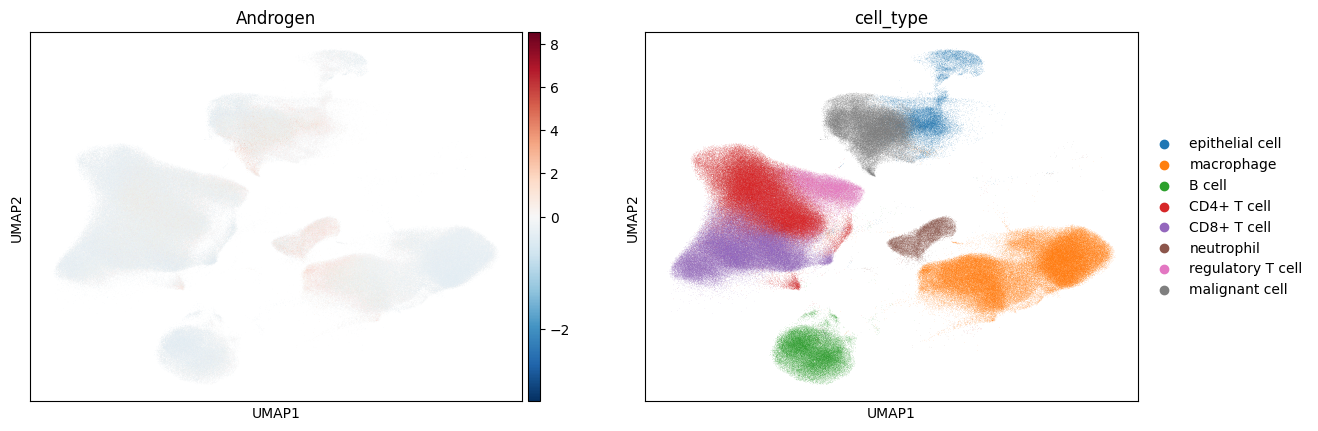

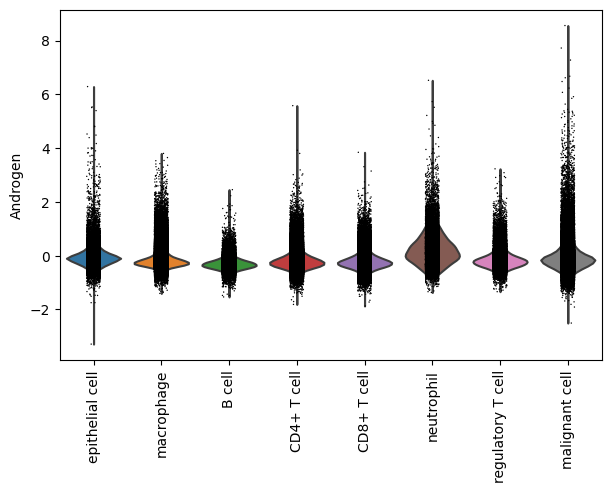

In [190]:
# Visualization
sc.pl.umap(acts, color=["Androgen", "cell_type"], cmap="RdBu_r", vcenter=0)
sc.pl.violin(acts, keys=["Androgen"], groupby="cell_type", rotation=90)

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


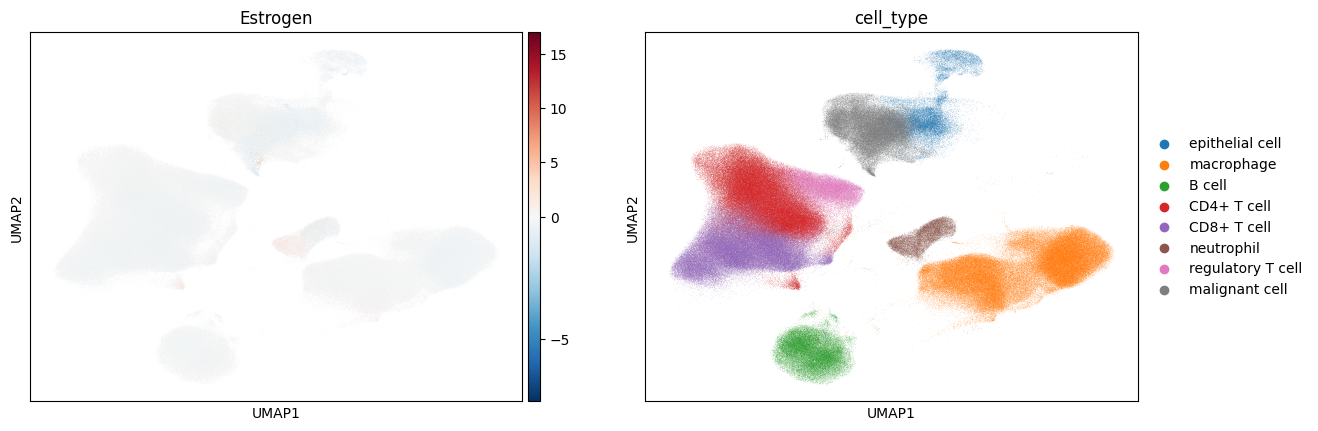

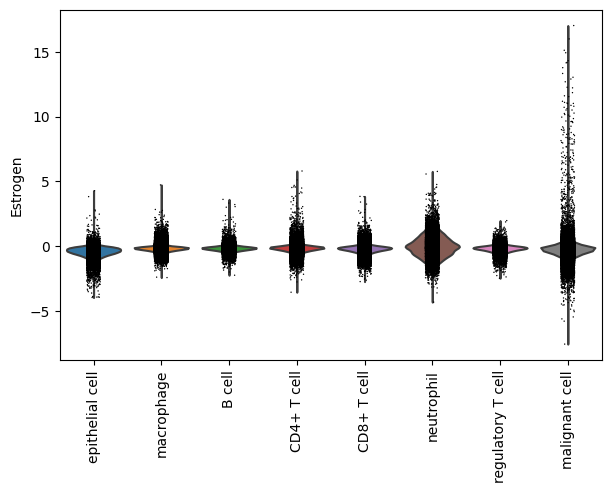

In [191]:
# Visualization
sc.pl.umap(acts, color=["Estrogen", "cell_type"], cmap="RdBu_r", vcenter=0)
sc.pl.violin(acts, keys=["Estrogen"], groupby="cell_type", rotation=90)

In [229]:
f"{resDir}/sc_pathway_{prefix}.png"

'/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/007_re_analysis/figures/decoupler/sc_pathway_tumor_and_normal.png'

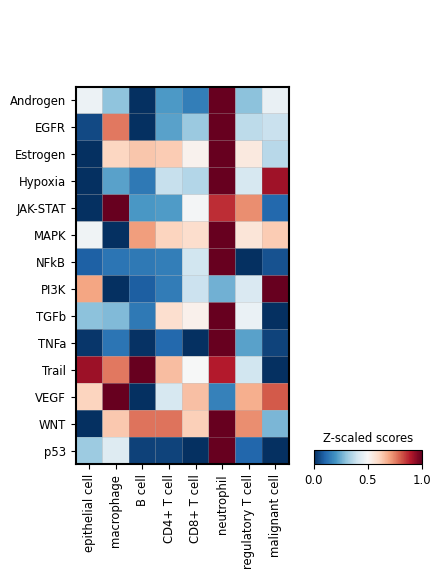

In [231]:
# Exploration
sc.pl.matrixplot(
    acts,
    var_names=acts.var_names,
    groupby="cell_type",
    dendrogram=False,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
    swap_axes=True,
    save=f"sc_pathway_{prefix}.png",
)

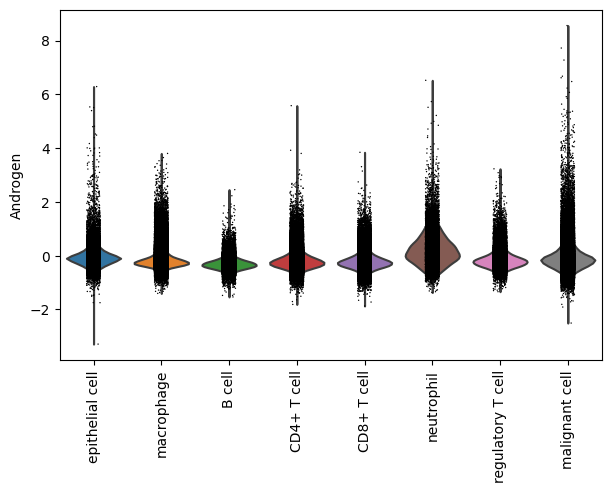

In [193]:
# Specific genes
sc.pl.violin(acts, keys=["Androgen"], groupby="cell_type", rotation=90)

## SC Transcription factor activity inference

In [194]:
net = dc.get_collectri(organism="human", split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [195]:
dc.run_ulm(
    mat=subset_adata,
    net=net,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
)


Running ulm on mat with 638804 samples and 17811 targets for 738 sources.


100%|██████████| 64/64 [04:15<00:00,  3.99s/it]


In [196]:
subset_adata.obsm["ulm_estimate"]

,ABL1,AEBP1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,...,ZNF384,ZNF395,ZNF410,ZNF423,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
AAACCCAAGAGCCATG-1_0-1,0.869942,-0.143168,-0.190176,-0.047719,0.174268,0.268042,1.988538,-0.123545,0.504966,-0.282351,...,-0.435771,-0.282371,-0.143167,-0.238637,-0.282367,-0.495190,-0.761817,2.009845,2.988480,2.508286
AAACCCAAGATTAGAC-1_0-1,-0.232329,-0.164265,-0.136988,-0.054750,0.115413,0.140151,0.612715,0.263465,0.901854,-0.010898,...,-0.415433,-0.245710,-0.071667,-0.273801,-0.167438,-0.131160,-0.060568,-0.089393,5.533345,-0.215422
AAACCCAAGGTCGCCT-1_0-1,1.462684,-0.102386,-0.064699,-0.034126,0.124627,0.293918,1.352671,0.454002,1.173064,-0.201922,...,-0.311640,-0.201936,-0.102386,-0.170660,-0.201934,-0.109647,-0.086529,-0.096530,0.875621,1.888616
AAACCCAAGTCATTGC-1_0-1,3.514848,0.173438,0.326874,-0.044887,0.163926,0.012648,1.149771,0.255960,1.818010,-0.265596,...,-0.269238,-0.265614,-0.134671,-0.224475,-0.005177,-0.198469,0.146577,-0.780575,0.874685,2.567810
AAACCCACACTCCTTG-1_0-1,5.650803,-0.163625,2.015935,-0.054537,0.199168,1.241402,3.627181,-0.431421,1.759542,0.067548,...,-0.498039,-0.322719,-0.163625,-0.272735,-0.322715,0.198398,-0.138284,-0.154266,1.007428,1.387564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGCCTTGG-1-38-8,1.185619,0.380476,0.337643,-0.025763,0.094089,0.955017,0.918206,0.624271,0.923412,-0.152444,...,-0.235277,-0.152455,-0.077297,-0.128841,-0.152453,-0.399643,-0.065326,-0.234722,0.281985,0.067831
TTTGTCACAGGTCGTC-1-38-8,1.232540,0.324653,0.359128,0.399793,0.137255,0.893163,1.317394,1.591164,3.024231,-0.222383,...,-0.343219,-0.222398,-0.112759,-0.187951,0.147332,-0.088290,-0.095296,-0.260957,0.544705,0.592863
TTTGTCACATCTATGG-1-38-8,0.961776,14.258555,2.734354,-0.036063,0.131703,2.381669,3.201545,3.275268,2.534260,-0.046838,...,-0.149403,-0.046842,-0.108199,-0.081816,-0.046841,-0.272879,-0.174708,-0.102011,0.663222,-0.017667
TTTGTCAGTGTTGGGA-1-38-8,1.184629,24.198160,0.683252,-0.031720,0.052768,1.938228,-0.370648,1.190950,2.530772,-0.187689,...,-0.258128,-0.070902,-0.095168,-0.158629,-0.129301,-0.224134,0.153129,-0.040872,0.780343,0.393963


In [197]:
subset_adata.obsm["collectri_ulm_estimate"] = subset_adata.obsm["ulm_estimate"].copy()
subset_adata.obsm["collectri_ulm_pvals"] = subset_adata.obsm["ulm_pvals"].copy()
subset_adata

AnnData object with n_obs × n_vars = 638804 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [232]:
acts = dc.get_acts(subset_adata, obsm_key="ulm_estimate")
acts

AnnData object with n_obs × n_vars = 638804 × 738
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    uns: '_scvi', 'ann_fine_colors', 'batch_condition', 'cell

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


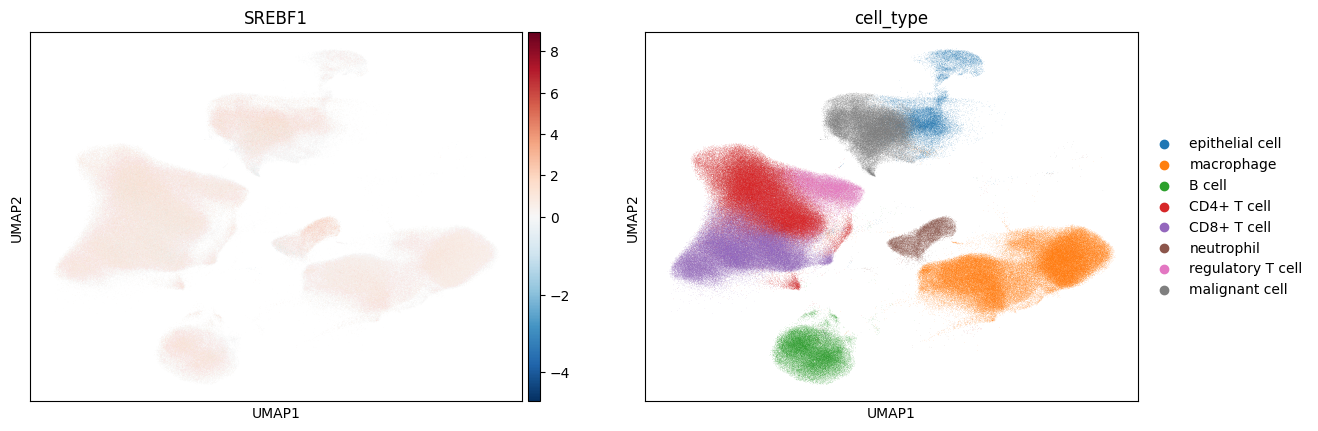

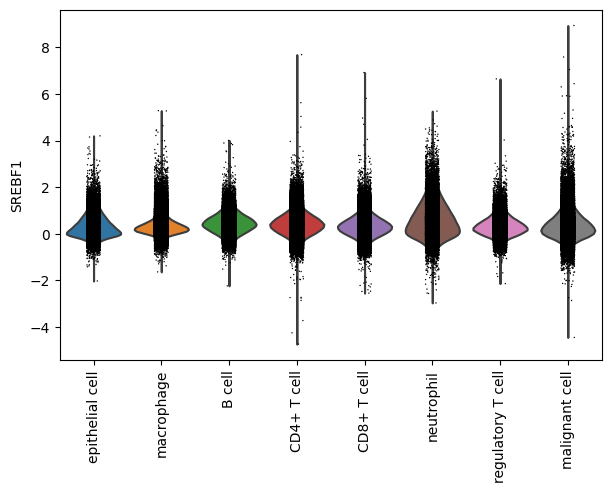

In [199]:
# Specific TF
sc.pl.umap(acts, color=["SREBF1", "cell_type"], cmap="RdBu_r", vcenter=0)
sc.pl.violin(acts, keys=["SREBF1"], groupby="cell_type", rotation=90)

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


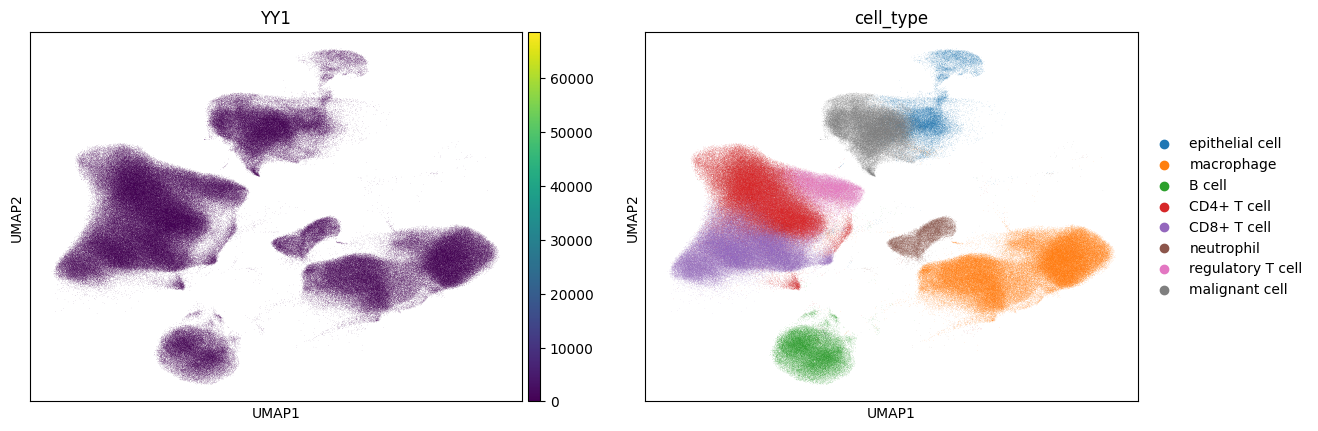

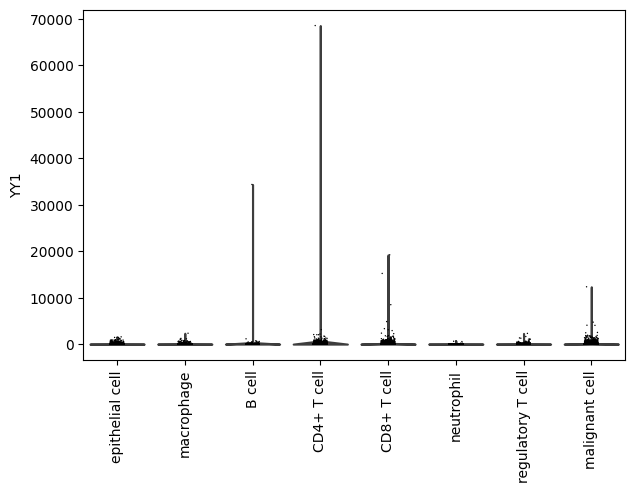

In [200]:
sc.pl.umap(subset_adata, color=["YY1", "cell_type"])
sc.pl.violin(subset_adata, keys=["YY1"], groupby="cell_type", rotation=90)

In [233]:
# Exploration
df = dc.rank_sources_groups(
    acts, groupby="cell_type", reference="rest", method="t-test_overestim_var"
)
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cell,rest,EBF1,235.731295,0.567763,0.0,0.0
1,B cell,rest,PHF5A,217.520180,0.824206,0.0,0.0
2,B cell,rest,ZBTB4,142.841309,4.696154,0.0,0.0
3,B cell,rest,PURA,139.695053,0.349477,0.0,0.0
4,B cell,rest,BCL6,139.692255,0.750174,0.0,0.0
...,...,...,...,...,...,...,...
5899,regulatory T cell,rest,SPIB,-92.744247,-0.391540,0.0,0.0
5900,regulatory T cell,rest,CTNNB1,-95.914985,-0.676809,0.0,0.0
5901,regulatory T cell,rest,ATF3,-96.423499,-1.546245,0.0,0.0
5902,regulatory T cell,rest,IRF8,-109.167739,-0.776010,0.0,0.0


In [234]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .groupby("group")["names"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'B cell': ['EBF1', 'PHF5A', 'ZBTB4'],
 'CD4+ T cell': ['MYC', 'NFX1', 'ZBTB4'],
 'CD8+ T cell': ['KLF13', 'TEAD1', 'IRF7'],
 'epithelial cell': ['NKX2-1', 'GRHL2', 'TTF1'],
 'macrophage': ['SPIB', 'HMGA1', 'RFXAP'],
 'malignant cell': ['SALL4', 'NFE2L2', 'TBPL1'],
 'neutrophil': ['CEBPB', 'PPARD', 'CEBPG'],
 'regulatory T cell': ['ZFX', 'NFX1', 'NFKB2']}

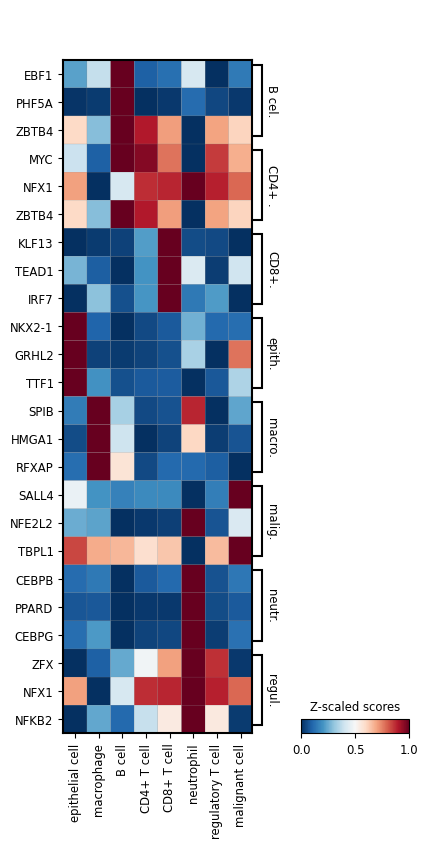

In [235]:
sc.pl.matrixplot(
    acts,
    source_markers,
    "cell_type",
    dendrogram=False,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
    swap_axes=True,
     save=f"sc_transcription_factor_{prefix}.png",
)

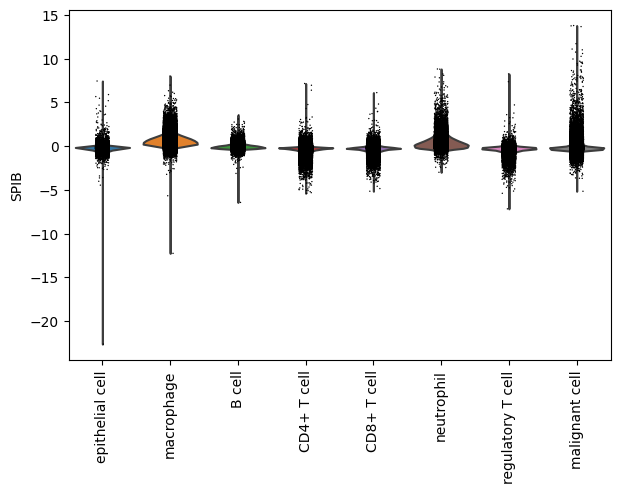

In [205]:
# Specific TF
sc.pl.violin(acts, keys=["SPIB"], groupby="cell_type", rotation=90)

## SC SigDB gene sets

In [206]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MSC,oncogenic_signatures,PKCA_DN.V1_DN
1,MSC,mirna_targets,MIR12123
2,MSC,chemical_and_genetic_perturbations,NIKOLSKY_BREAST_CANCER_8Q12_Q22_AMPLICON
3,MSC,immunologic_signatures,GSE32986_UNSTIM_VS_GMCSF_AND_CURDLAN_LOWDOSE_S...
4,MSC,chemical_and_genetic_perturbations,BENPORATH_PRC2_TARGETS
...,...,...,...
2407729,OR2W5P,immunologic_signatures,GSE22601_DOUBLE_NEGATIVE_VS_CD8_SINGLE_POSITIV...
2407730,OR2W5P,immunologic_signatures,KANNAN_BLOOD_2012_2013_TIV_AGE_65PLS_REVACCINA...
2407731,OR52L2P,immunologic_signatures,GSE22342_CD11C_HIGH_VS_LOW_DECIDUAL_MACROPHAGE...
2407732,CSNK2A3,immunologic_signatures,OCONNOR_PBMC_MENVEO_ACWYVAX_AGE_30_70YO_7DY_AF...


In [207]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

,genesymbol,collection,geneset
11,MSC,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
149,ICOSLG,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
223,ICOSLG,hallmark,HALLMARK_INFLAMMATORY_RESPONSE
270,ICOSLG,hallmark,HALLMARK_ALLOGRAFT_REJECTION
398,FOSL2,hallmark,HALLMARK_HYPOXIA
...,...,...,...
878342,FOXO1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878418,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878512,PDX1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878605,INS,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [208]:
dc.run_ora(
    mat=subset_adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True
)

Running ora on mat with 638804 samples and 17811 targets for 50 sources.


100%|██████████| 638804/638804 [11:30<00:00, 924.83it/s] 


In [209]:
subset_adata.obsm['ora_estimate']

source,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_HYPOXIA,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_COAGULATION,HALLMARK_P53_PATHWAY,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_UV_RESPONSE_UP,HALLMARK_IL6_JAK_STAT3_SIGNALING,...,HALLMARK_HEDGEHOG_SIGNALING,HALLMARK_GLYCOLYSIS,HALLMARK_DNA_REPAIR,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_APICAL_SURFACE,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_HEME_METABOLISM,HALLMARK_SPERMATOGENESIS,HALLMARK_PANCREAS_BETA_CELLS,HALLMARK_OXIDATIVE_PHOSPHORYLATION
AAACCCAAGAGCCATG-1_0-1,1.463802,1.480218,11.120653,2.188393,1.001787,0.163523,3.642362,8.880812,0.798846,1.073040,...,-0.000000,0.179880,3.417419,0.452499,0.069145,2.179716,0.011093,0.062879,0.158357,7.153353
AAACCCAAGATTAGAC-1_0-1,0.738158,0.009117,1.267177,1.267177,1.530495,1.203815,1.778759,3.612347,1.048966,0.277518,...,-0.000000,3.250860,0.875740,0.178394,-0.000000,2.643304,2.232238,0.062879,0.969217,26.047981
AAACCCAAGGTCGCCT-1_0-1,1.194127,1.208422,7.345171,3.336049,0.587366,0.008491,5.531508,4.511173,0.798846,1.450006,...,-0.000000,0.976602,0.645624,0.452499,0.069145,1.372306,0.445772,0.019354,0.969217,5.531508
AAACCCAAGTCATTGC-1_0-1,6.011438,0.748410,9.796189,1.854979,0.587366,0.031157,5.028793,4.991599,5.216590,0.277518,...,0.093436,0.976602,0.645624,1.141798,0.248753,2.643304,0.445772,0.019354,0.490057,5.531508
AAACCCACACTCCTTG-1_0-1,11.476524,1.480218,3.764982,3.764982,0.587366,0.287267,4.083592,6.549745,5.775545,0.749677,...,-0.000000,0.976602,0.875740,1.776429,-0.000000,3.143951,0.812638,0.003133,0.969217,8.324364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGCCTTGG-1-38-8,7.680615,1.208422,5.180562,6.775996,2.166781,0.079924,6.053525,4.051207,0.583912,1.073040,...,-0.000000,1.222872,3.897798,1.141798,0.248753,1.033262,0.198859,-0.000000,0.490057,9.563098
TTTGTCACAGGTCGTC-1-38-8,15.819367,2.826092,7.345171,7.932212,2.903508,0.287267,8.324364,9.505876,4.168552,2.350909,...,0.317946,1.222872,1.141798,1.776429,0.069145,4.850251,0.614175,0.062879,0.969217,18.266846
TTTGTCACATCTATGG-1-38-8,15.819367,2.103164,10.450481,11.806371,2.903508,4.775362,9.563098,14.314867,5.216590,1.450006,...,0.667356,5.571449,1.776429,4.404043,0.069145,3.679764,0.812638,0.062879,0.490057,17.464825
TTTGTCAGTGTTGGGA-1-38-8,22.364283,5.028793,11.806371,10.450481,6.181751,4.775362,10.206888,12.866558,5.775545,3.427689,...,0.093436,4.581011,0.875740,2.963938,0.248753,3.143951,0.812638,0.019354,0.490057,29.813120


In [236]:
#Visualization
acts = dc.get_acts(subset_adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 638804 × 50
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    uns: '_scvi', 'ann_fine_colors', 'batch_condition', 'cell_

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


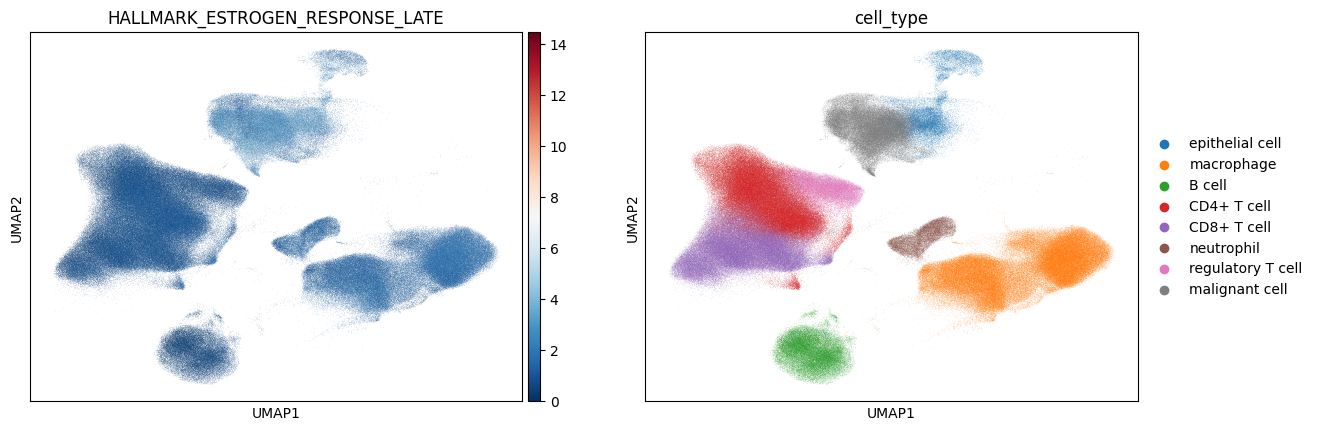

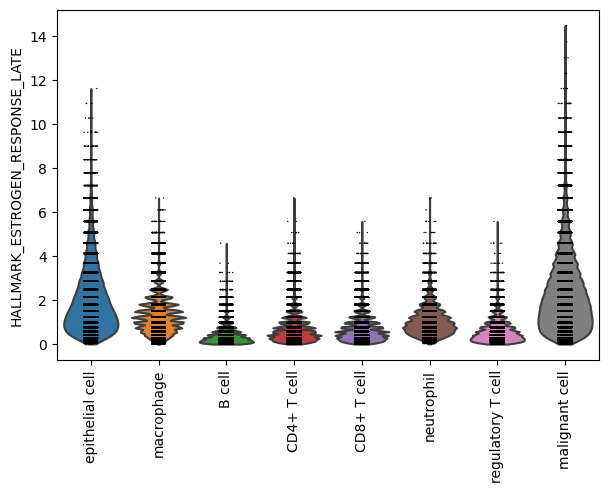

In [214]:
sc.pl.umap(acts, color=['HALLMARK_ESTROGEN_RESPONSE_LATE', 'cell_type'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['HALLMARK_ESTROGEN_RESPONSE_LATE'], groupby='cell_type', rotation=90)

In [237]:
#Exploration
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cell,rest,HALLMARK_MYC_TARGETS_V2,40.432422,0.234690,0.000000,0.000000
1,B cell,rest,HALLMARK_KRAS_SIGNALING_DN,39.819596,0.031460,0.000000,0.000000
2,B cell,rest,HALLMARK_MYC_TARGETS_V1,-1.318722,-0.073572,0.187266,0.187266
3,B cell,rest,HALLMARK_E2F_TARGETS,-3.958535,-0.065027,0.000075,0.000077
4,B cell,rest,HALLMARK_G2M_CHECKPOINT,-4.065319,-0.060336,0.000048,0.000050
...,...,...,...,...,...,...,...
395,regulatory T cell,rest,HALLMARK_XENOBIOTIC_METABOLISM,-92.658672,-0.652853,0.000000,0.000000
396,regulatory T cell,rest,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,-94.244515,-0.746195,0.000000,0.000000
397,regulatory T cell,rest,HALLMARK_CHOLESTEROL_HOMEOSTASIS,-97.170307,-0.918663,0.000000,0.000000
398,regulatory T cell,rest,HALLMARK_COMPLEMENT,-99.643894,-2.332429,0.000000,0.000000


In [238]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'B cell': ['HALLMARK_MYC_TARGETS_V2',
  'HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_MYC_TARGETS_V1'],
 'CD4+ T cell': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_WNT_BETA_CATENIN_SIGNALING',
  'HALLMARK_MYC_TARGETS_V2'],
 'CD8+ T cell': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_MITOTIC_SPINDLE',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE'],
 'epithelial cell': ['HALLMARK_ESTROGEN_RESPONSE_EARLY',
  'HALLMARK_ESTROGEN_RESPONSE_LATE',
  'HALLMARK_NOTCH_SIGNALING'],
 'macrophage': ['HALLMARK_COMPLEMENT',
  'HALLMARK_COAGULATION',
  'HALLMARK_CHOLESTEROL_HOMEOSTASIS'],
 'malignant cell': ['HALLMARK_ESTROGEN_RESPONSE_EARLY',
  'HALLMARK_ESTROGEN_RESPONSE_LATE',
  'HALLMARK_GLYCOLYSIS'],
 'neutrophil': ['HALLMARK_TNFA_SIGNALING_VIA_NFKB',
  'HALLMARK_INFLAMMATORY_RESPONSE',
  'HALLMARK_IL6_JAK_STAT3_SIGNALING'],
 'regulatory T cell': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_IL2_STAT5_SIGNALING',
  'HALLMARK_PI3K_AKT_MTOR_SIGNALING']}

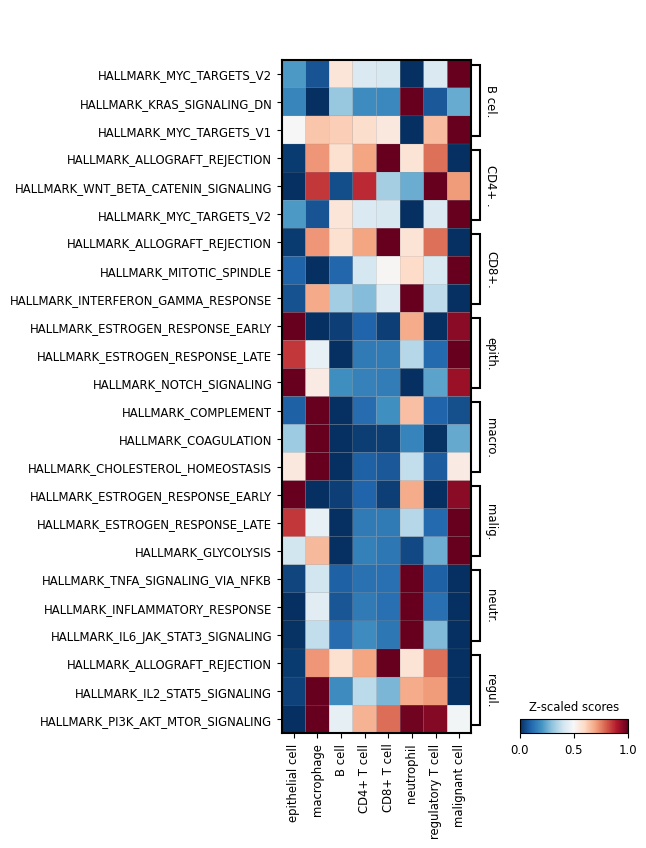

In [239]:
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True,     save=f"sc_biological_process_{prefix}.png",)

In [222]:
subset_adata.write_h5ad(f"{path}/out/007_re_analysis/tables/subset_adata_estimates_tumor_and_normal.h5ad")
#subset_adata = sc.read_h5ad(f"{path}/out/007_re_analysis/tables/input/subset_adata_estimates_tumor_and_normal.h5ad")

In [223]:
subset_adata.obs.origin.value_counts()

tumor_primary      433044
normal_adjacent    205760
Name: origin, dtype: int64